In [1]:
import os

import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm_notebook as tqdm

import pickle
import json

from io import StringIO, BytesIO

import boto3
from minio import Minio
from minio.error import ResponseError, NoSuchKey

from ptc_scmt.speed_profile_handling import compute_features

In [2]:
INPUT_BUCKET_NAME = "odometryclassification"

In [3]:
INPUTDIRNAME = "events1min"

In [4]:
with open("config.json", "r") as f:
    config = json.load(f)

In [5]:
minioClient = Minio(config["minio_config"]["endpoint_url"].replace("http://","").rstrip("/"),
                    access_key=config["minio_config"]["aws_access_key_id"],
                    secret_key=config["minio_config"]["aws_secret_access_key"],
                    secure=False)

In [6]:
pd.set_option('display.max_columns', None)

In [7]:
speed_vars = ["axle1RawSpeed", 
              "axle2RawSpeed", 
              "trainSpeed"
             ]

In [8]:
def get_df_from_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)["data"]

In [9]:
def get_pickle_from_minio(filename):
    try:
        data = minioClient.get_object(INPUT_BUCKET_NAME, filename)
    except NoSuchKey:
        pass

    data = BytesIO(data.read())
    
    return pickle.load(data)["data"]

In [10]:
def plot_profiles(df, metadata=None):
    plt.figure(figsize=(15,5))
    if metadata is not None:
        vid = metadata['VehicleID']
        rel = metadata['Relative Error (%)']
        com = metadata["Comment"]
        plt.title(f"Speed profiles - VehicleID {vid}, Relative Error = {rel}, reason: {com}")
    plt.plot(df["axle1RawSpeed"], label="axle1RawSpeed")
    plt.plot(df["axle2RawSpeed"], label="axle2RawSpeed")
    plt.plot(df["trainSpeed"], label="trainSpeed")
    plt.legend()
    plt.show()

In [11]:
def plot_features(df, features=[], metadata=None):    
    for f in features:
        plt.figure(figsize=(10,7))
        if metadata is not None:
            vid = metadata['VehicleID']
            rel = metadata['Relative Error (%)']
            com = metadata["Comment"]
            plt.title(f"Speed profiles - VehicleID {vid}, Relative Error = {rel}, reason: {com}")
        else:
            plt.title(f)

        plt.hist(df[df["is_nominal"] == True][f],  bins=40, density=True, range=(df[f].min()-1e-6, df[f].max()+1e-6), alpha=0.5, label="nominal")
        plt.hist(df[df["is_nominal"] == False][f], bins=40, density=True, range=(df[f].min()-1e-6, df[f].max()+1e-6), alpha=0.5, label="anomalous")
        plt.legend()
        plt.show()

In [12]:
client = boto3.client("s3", 
                      endpoint_url=config["minio_config"]["endpoint_url"],
                      aws_access_key_id=config["minio_config"]["aws_access_key_id"],
                      aws_secret_access_key=config["minio_config"]["aws_secret_access_key"],
                      region_name=config["minio_config"]["region_name"])

paginator = client.get_paginator("list_objects_v2")

event_files = list()
for page in paginator.paginate(Bucket=INPUT_BUCKET_NAME, Prefix=f"{INPUTDIRNAME}/"):
    if "Contents" in page.keys():
        for obj in page["Contents"]:
            event_files.append(obj["Key"])
            

In [13]:
data = list()
event_names = list()
for event in tqdm(event_files):
        
    df_event = get_pickle_from_minio(event)
    
    if df_event.shape[0] == 0:
        continue
            
    df_event = df_event[speed_vars]    
    features = compute_features(df_event, *speed_vars)
    
    if "nominal" in event:
        features["is_nominal"] = True
    else:
        features["is_nominal"] = False
        
    data.append(features)
    event_names.append("/".join(event.split(".")[0].split("/")[1:]))
    

In [14]:
idx = ["/".join(e.split(".")[0].split("/")[1:]) for e in event_files]
df_features = pd.DataFrame.from_records(data, 
                                        index=event_names)

In [15]:
df_features.head()

,axle1_minus_train_speed_min,axle1_minus_train_speed_max,axle1_minus_train_speed_mean,axle1_minus_train_speed_std,axle1_minus_train_speed_median,axle1_acc_min,axle1_acc_max,axle1_acc_mean,axle1_acc_std,axle1_acc_median,axle1_train_acc_min,axle1_train_acc_max,axle1_train_acc_mean,axle1_train_acc_std,axle1_train_acc_median,axle2_minus_train_speed_min,axle2_minus_train_speed_max,axle2_minus_train_speed_mean,axle2_minus_train_speed_std,axle2_minus_train_speed_median,axle2_acc_min,axle2_acc_max,axle2_acc_mean,axle2_acc_std,axle2_acc_median,axle2_train_acc_min,axle2_train_acc_max,axle2_train_acc_mean,axle2_train_acc_std,axle2_train_acc_median,axle1_minus_axle2_integral,axle1_minus_axle2_integral_pos,axle1_minus_axle2_integral_neg,axle1_minus_train_integral,axle1_minus_train_integral_pos,axle1_minus_train_integral_neg,axle2_minus_train_integral,axle2_minus_train_integral_pos,axle2_minus_train_integral_neg,is_nominal
4005_2020-02-04--07-52-13755000,-18,1,-4.016529,5.740185,0.0,-2.0,1.0,-0.175000,0.784969,0.0,-2.0,1.0,0.0000,0.733359,0.0,-18,1,-4.107438,5.660980,0.0,-2.0,1.0,-0.175000,0.774190,0.0,-2.0,1.0,0.0000,0.661041,0.0,5.5,6.5,0.0,-243.0,6.0,-249.0,-243.0,26.0,-2254.5,False
4018_2020-02-25--06-58-04567000,-17,0,-4.090909,5.165591,-1.0,-2.0,0.0,-0.583333,0.705123,0.0,-2.0,5.0,0.0000,0.850111,0.0,-17,0,-4.165289,5.124040,-1.0,-2.0,0.0,-0.583333,0.716942,0.0,-2.0,5.0,0.0000,0.898177,0.0,4.5,5.0,0.0,-247.5,0.0,-247.5,-247.5,0.0,-252.0,False
4018_2020-03-16--04-49-06952000,-24,0,-6.942149,7.762407,-4.0,-2.0,1.0,-0.333333,0.714006,0.0,-2.0,1.0,0.0000,0.721809,0.0,-24,1,-6.884298,7.807251,-4.0,-2.0,1.0,-0.333333,0.714006,0.0,-2.0,1.0,0.0000,0.710072,0.0,-3.5,0.0,-17.5,-420.0,0.0,-840.0,-420.0,7.5,-418.0,False
4018_2020-03-16--04-49-26952000,-24,0,-8.543210,8.345732,-7.0,-2.0,0.0,-0.125000,0.460462,0.0,-2.0,1.0,0.2125,0.630325,0.0,-24,0,-8.543210,8.345732,-7.0,-2.0,0.0,-0.125000,0.460462,0.0,-2.0,1.0,0.2125,0.630325,0.0,0.0,0.0,0.0,-346.0,0.0,-346.0,-346.0,0.0,-346.0,False
4026_2020-01-20--04-48-25560000,-1,0,-0.008264,0.090909,0.0,-2.0,1.0,-0.216667,0.537397,0.0,-1.0,1.0,0.0000,0.129641,0.0,-1,0,-0.033058,0.179531,0.0,-1.0,1.0,-0.216667,0.521525,0.0,-1.0,1.0,0.0000,0.259281,0.0,1.5,34.0,0.0,-0.5,0.0,0.0,-0.5,0.0,-34.0,False


In [16]:
def plot_features_grid(df, features=[], metadata=None, log=False):  
    
    n_features = len(features)
    
    n_cols = 5
    nrows = n_features//n_cols if (n_features%n_cols == 0) else n_features//n_cols + 1
    fig, axs = plt.subplots(nrows, n_cols, figsize=(n_cols*5,nrows*4))
    axs = axs.ravel()
    
    for i,f in enumerate(features):
        if metadata is not None:
            vid = metadata['VehicleID']
            rel = metadata['Relative Error (%)']
            com = metadata["Comment"]
            axs[i].set_title(f"Speed profiles - VehicleID {vid}, Relative Error = {rel}, reason: {com}")
        else:
            axs[i].set_title(f)

        xn, binsn, pn = axs[i].hist(df[df["is_nominal"] == True][f],  bins=40, density=True, range=(df[f].min()-1e-6, df[f].max()+1e-6), alpha=0.5, label="nominal")
        xa, binsa, pa = axs[i].hist(df[df["is_nominal"] == False][f], bins=40, density=True, range=(df[f].min()-1e-6, df[f].max()+1e-6), alpha=0.5, label="anomalous")
        
        for item in pn:
            item.set_height(item.get_height()/np.max(xn))
        for item in pa:
            item.set_height(item.get_height()/np.max(xa))
        if log:
            axs[i].set_yscale('log')
            axs[i].set_ylim(0, 10)
        else:
            axs[i].set_ylim(0, 1.2)

    plt.legend()
    plt.show()

W1215 13:58:31.313750 140065206695680 legend.py:1282] No handles with labels found to put in legend.


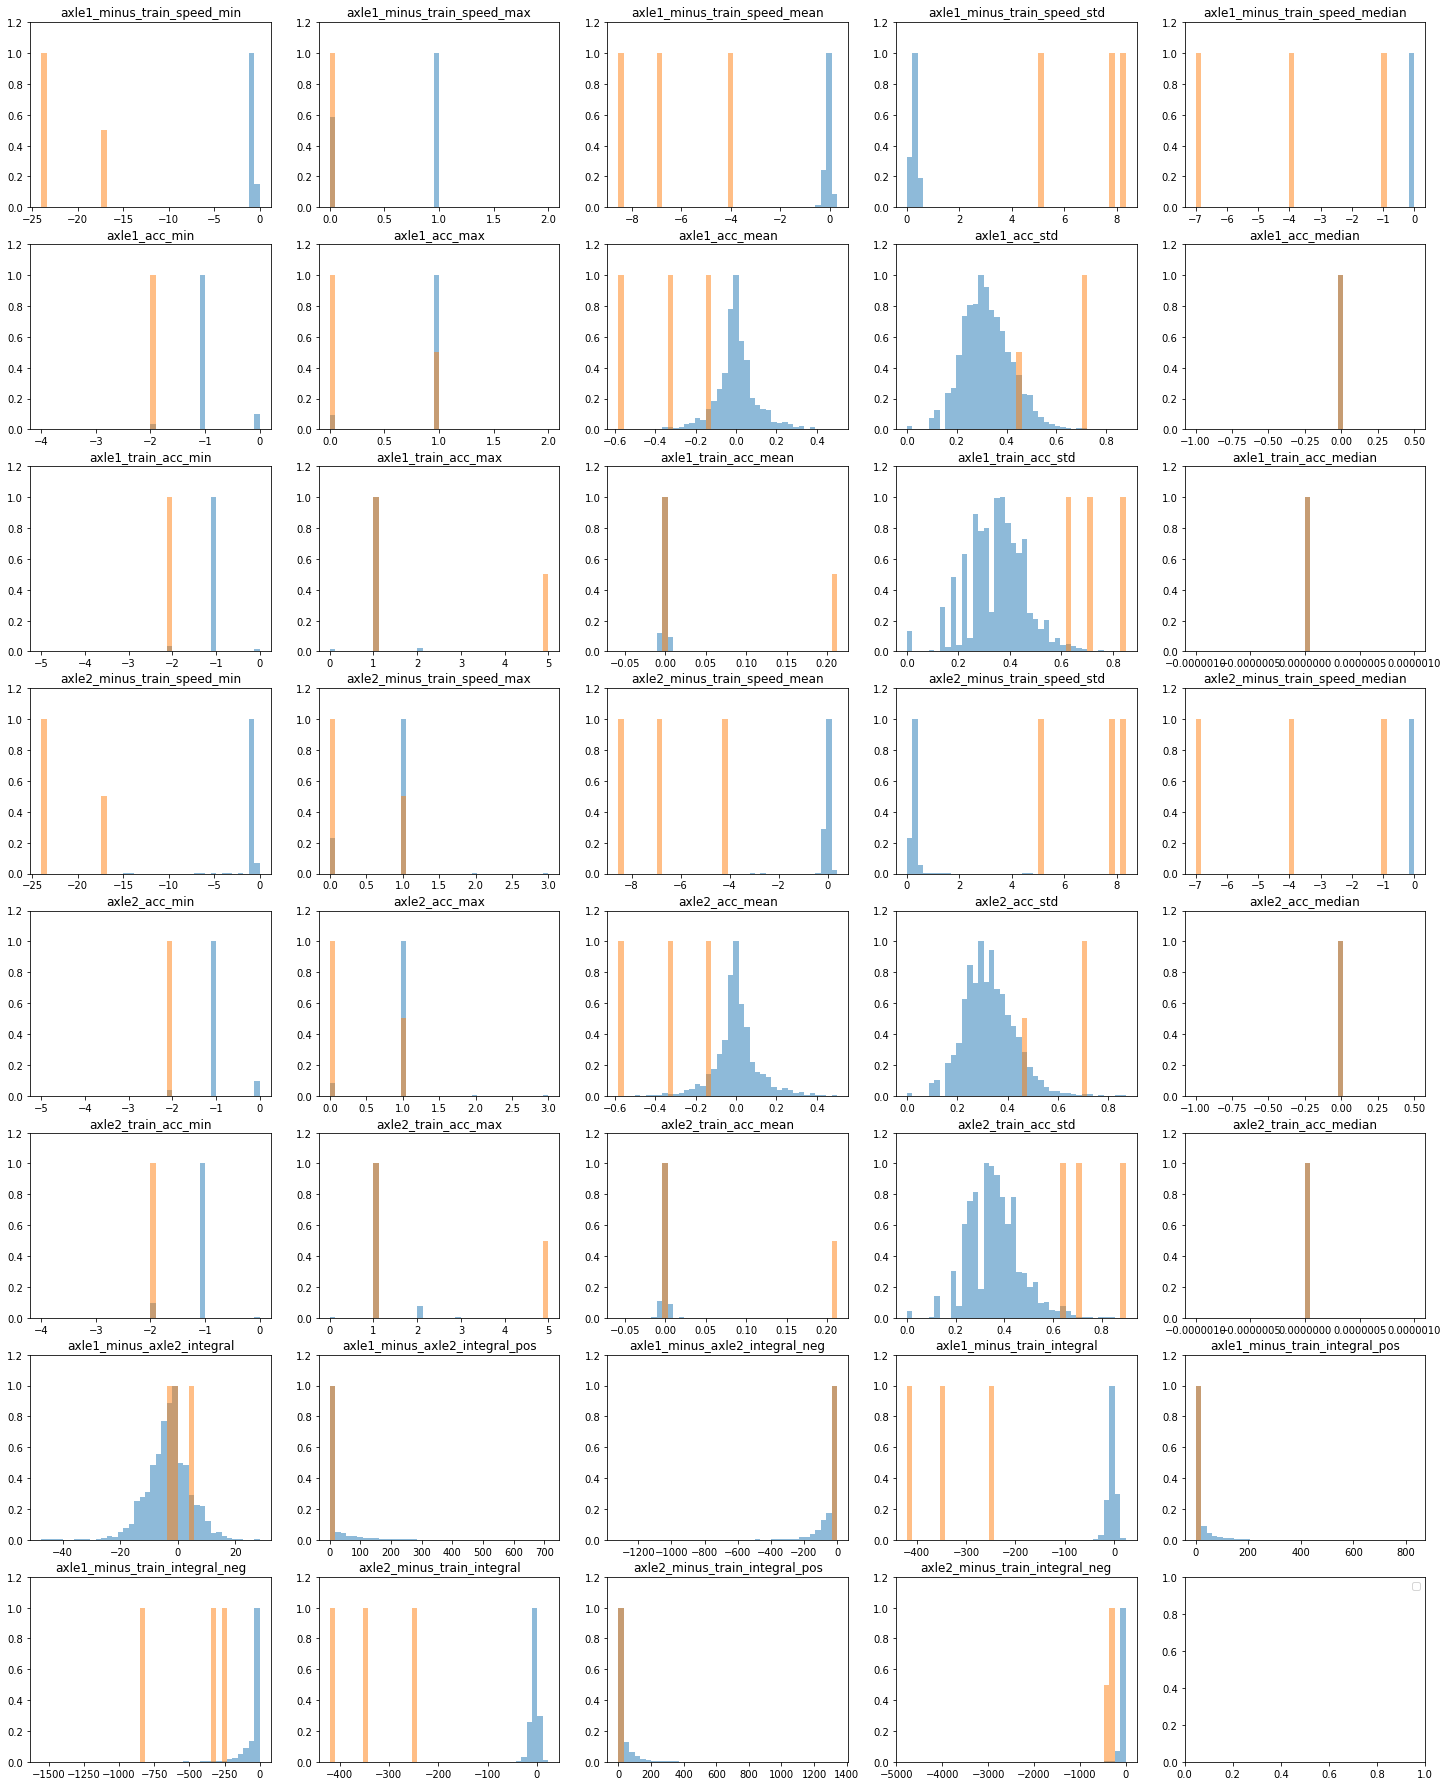

In [17]:
df_4018 = df_features[["4018" in f for f in df_features.index]]

plot_features_grid(df_4018, df_4018.columns.drop("is_nominal"))

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


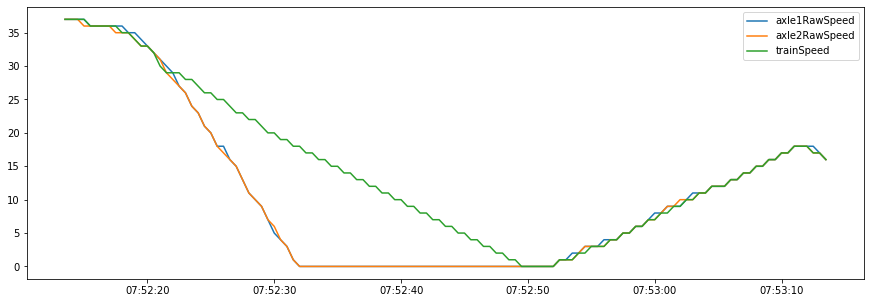

-0.175
{'axle1_acc_max': 1.0,
 'axle1_acc_mean': -0.175,
 'axle1_acc_median': 0.0,
 'axle1_acc_min': -2.0,
 'axle1_acc_std': 0.7849690889380521,
 'axle1_minus_axle2_integral': 5.5,
 'axle1_minus_axle2_integral_neg': 0,
 'axle1_minus_axle2_integral_pos': 6.5,
 'axle1_minus_train_integral': -243.0,
 'axle1_minus_train_integral_neg': -249.0,
 'axle1_minus_train_integral_pos': 6.0,
 'axle1_minus_train_speed_max': 1,
 'axle1_minus_train_speed_mean': -4.016528925619835,
 'axle1_minus_train_speed_median': 0.0,
 'axle1_minus_train_speed_min': -18,
 'axle1_minus_train_speed_std': 5.740185059552204,
 'axle1_train_acc_max': 1.0,
 'axle1_train_acc_mean': 0.0,
 'axle1_train_acc_median': 0.0,
 'axle1_train_acc_min': -2.0,
 'axle1_train_acc_std': 0.7333587976225691,
 'axle2_acc_max': 1.0,
 'axle2_acc_mean': -0.175,
 'axle2_acc_median': 0.0,
 'axle2_acc_min': -2.0,
 'axle2_acc_std': 0.7741897363690377,
 'axle2_minus_train_integral': -243.0,
 'axle2_minus_train_integral_neg': -2254.5,
 'axle2_minus_tra

In [18]:
from pprint import pprint

for event in tqdm(event_files):
        
    df_event = get_pickle_from_minio(event)
    if df_event.shape[0] == 0:
        continue
        
    df_event = df_event.resample("500L").mean()
    
    for v in speed_vars:
        df_event[v] = df_event[v].astype(np.int16)


    plot_profiles(df_event)
    print(df_event["axle1RawSpeed"].diff().dropna().mean())
#     df_event["axle1RawSpeed"].diff().dropna().plot()
#     df_event["axle1RawSpeed"].plot()
    
    
    features = compute_features(df_event, *speed_vars)
    pprint(features)
    break

In [19]:
df_features.to_csv("features1min.csv")